In [14]:
import cv2
import numpy as np
from IAMLTools import getContourProperties
from voteCounter import detectMark, getVote, pointWithinRectangle
from glob import glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
regions = np.load('data/stemboks.npy')
rects = [i['rect'] for i in regions]
warped = np.load('temp/warped.npy')

## Loading contours into dataframe

In [3]:
paths = glob('temp/cn*.npy')
contours = []

for path in paths:
    cnt = np.load(path)
    contours.append(cnt)

In [4]:
property_names = ['IsConvex', 'Area' , 'Centroid', 'Extend', 'Solidity']
props = []
for contour in contours:
    for i in contour:
        props.append(getContourProperties(i, properties=property_names))

In [5]:
df = pd.DataFrame(props)

## Adjust DF

Rectangle for konservative

In [7]:
c_rect = regions[-1:][0]['rect']

Create columns with  contour centroid vote location and label for actual vote

In [8]:
df['Vote'] = df.Centroid.apply(lambda x: getVote(x, regions))
df['Label'] = df.Centroid.apply(lambda x: pointWithinRectangle(x, c_rect))

Remove contours with centroid = (-1,-1)

In [9]:
df = df[df.Centroid != (-1, -1)]

In [32]:
df.head()

,Area,Centroid,Extend,IsConvex,Solidity,Vote,Label
0,6.0,"(439, 337)",0.093750,False,0.131868,T……….Km,False
4,6.0,"(441, 501)",0.107143,False,0.164384,Det Konservative Folkeparti,True
9,2.0,"(442, 504)",0.222222,True,1.000000,Det Konservative Folkeparti,True
10,9.5,"(440, 503)",0.150794,False,0.220930,Det Konservative Folkeparti,True
13,1.5,"(201, 454)",0.093750,False,0.272727,None,False


In [28]:
corr = df.corr()

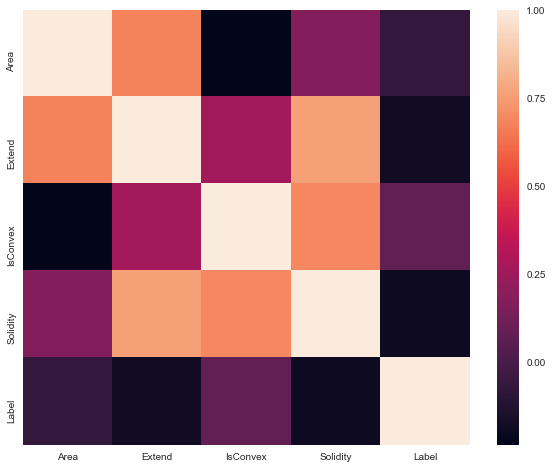

In [30]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corr)

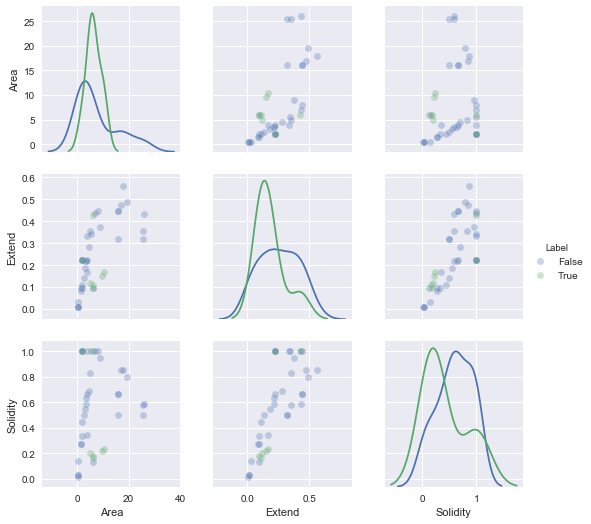

In [31]:
sns.pairplot(df, 
             vars=['Area', 'Extend', 'Solidity'], 
             hue="Label",
             plot_kws=dict(alpha=0.3),
             diag_kind='kde'
    )